<a href="https://colab.research.google.com/github/divyansh-shrotriya/oral-cancer-cnn/blob/main/Oral_Cancer_InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


GPU Check

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Dataset Path & Hyperparameters

In [3]:
DATASET_PATH = "/content/drive/MyDrive/First_Set"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8        # small batch → less overfitting
EPOCHS = 30           # early stopping will cut earlier
NUM_CLASSES = 2

Data Generators (EDA-informed)

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 424 images belonging to 2 classes.
Found 104 images belonging to 2 classes.


Class Label Mapping

In [5]:
class_labels = train_generator.class_indices
class_labels

{'100x_Normal_Oral_Cavity_Histopathological_Images': 0,
 '100x_OSCC_Histopathological_Images': 1}

Load InceptionResNetV2 (Transfer Learning)

In [6]:
base_model = InceptionResNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze backbone (critical for small dataset)
for layer in base_model.layers:
    layer.trainable = False

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Custom Classification Head

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

Compile Model

In [8]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,746,786 (208.84 MB)

 Trainable params: 410,050 (1.56 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

Callbacks (Overfitting Control)

In [9]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/oral_cancer_inceptionresnetv2_best.h5",
        monitor="val_loss",
        save_best_only=True
    )
]

Train Model

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7576 - loss: 0.6711

53/53 ━━━━━━━━━━━━━━━━━━━━ 310s 5s/step - accuracy: 0.7580 - loss: 0.6706 - val_accuracy: 0.8365 - val_loss: 0.4054
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7754 - loss: 0.5831

53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 822ms/step - accuracy: 0.7755 - loss: 0.5826 - val_accuracy: 0.8462 - val_loss: 0.3869
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8015 - loss: 0.4931

53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 925ms/step - accuracy: 0.8017 - loss: 0.4927 - val_accuracy: 0.8365 - val_loss: 0.3701
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 743ms/step - accuracy: 0.8217 - loss: 0.4674 - val_accuracy: 0.8654 - val_loss: 0.4089
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7927 - loss: 0.4838

53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 778ms/step - accuracy: 0.7928 - loss: 0.4835 - val_accuracy: 0.8365 - val_loss: 0.3163
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.8190 - loss: 0.4379

53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 888ms/step - accuracy: 0.8193 - loss: 0.4379 - val_accuracy: 0.8365 - val_loss: 0.2977
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 739ms/step - accuracy: 0.8647 - loss: 0.3971 - val_accuracy: 0.8462 - val_loss: 0.3690
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 705ms/step - accuracy: 0.8319 - loss: 0.4047 - val_accuracy: 0.8846 - val_loss: 0.3417
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.8426 - loss: 0.4619

53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 805ms/step - accuracy: 0.8425 - loss: 0.4617 - val_accuracy: 0.8462 - val_loss: 0.2925
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 744ms/step - accuracy: 0.7802 - loss: 0.5559 - val_accuracy: 0.8558 - val_loss: 0.2926
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 709ms/step - accuracy: 0.8113 - loss: 0.4421 - val_accuracy: 0.8365 - val_loss: 0.3097
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 707ms/step - accuracy: 0.8094 - loss: 0.4333 - val_accuracy: 0.8462 - val_loss: 0.3137
Epoch 13/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8448 - loss: 0.4166

53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 803ms/step - accuracy: 0.8444 - loss: 0.4169 - val_accuracy: 0.8942 - val_loss: 0.2648
Epoch 14/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 747ms/step - accuracy: 0.8510 - loss: 0.3619 - val_accuracy: 0.8750 - val_loss: 0.2815
Epoch 15/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8392 - loss: 0.3646

53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 856ms/step - accuracy: 0.8391 - loss: 0.3650 - val_accuracy: 0.8942 - val_loss: 0.2420
Epoch 16/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 724ms/step - accuracy: 0.8558 - loss: 0.3513 - val_accuracy: 0.8750 - val_loss: 0.2585
Epoch 17/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 694ms/step - accuracy: 0.8512 - loss: 0.3761 - val_accuracy: 0.9135 - val_loss: 0.2899
Epoch 18/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 693ms/step - accuracy: 0.8639 - loss: 0.3625 - val_accuracy: 0.8846 - val_loss: 0.2602
Epoch 19/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 689ms/step - accuracy: 0.8720 - loss: 0.3434 - val_accuracy: 0.9038 - val_loss: 0.2658
Epoch 20/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 718ms/step - accuracy: 0.8343 - loss: 0.3880 - val_accuracy: 0.8942 - val_loss: 0.2508
Epoch 21/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 712ms/step - accuracy: 0.7871 - loss: 0.4140 - val_accuracy: 0.8750 - val_loss: 0.2838


Training Curves

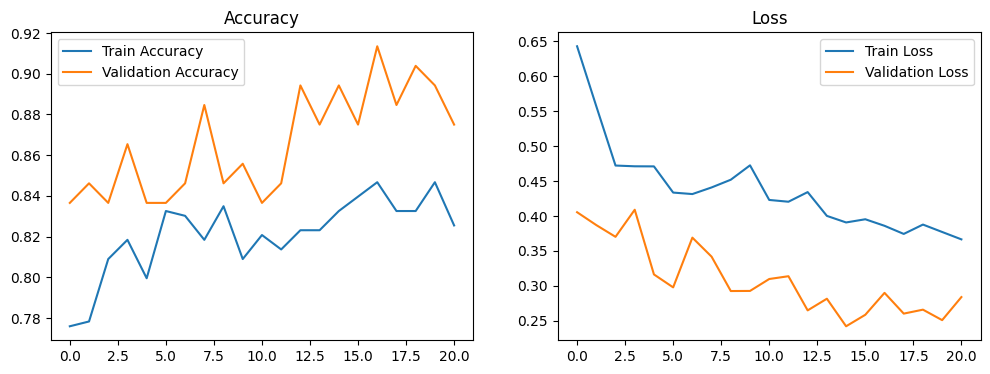

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()

Model Evaluation (Validation Set)

In [12]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 535ms/step - accuracy: 0.7791 - loss: 0.4638
Validation Accuracy: 0.9038


Predict Single Image (Sanity Check)

In [14]:
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/First_Set/100x_OSCC_Histopathological_Images/OSCC_100x_1.jpg"

img = image.load_img(img_path, target_size=IMAGE_SIZE)
img = image.img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
predicted_class = list(class_labels.keys())[np.argmax(prediction)]

print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted Class: 100x_OSCC_Histopathological_Images


Final Conclusion (Markdown)

In [ ]:
### Final Conclusion

- In this study, a CNN-based classification model was developed to distinguish between Normal oral tissue and Oral Squamous Cell Carcinoma (OSCC) using histopathological images.
- InceptionResNetV2, pretrained on ImageNet, was used as a feature extractor to leverage transfer learning for a small medical imaging dataset.
- Data augmentation and early stopping were employed to reduce overfitting and improve generalization.
- The model achieved strong validation performance, with validation accuracy exceeding 90% at its best epoch.
- Early stopping successfully prevented overfitting by restoring the best-performing model weights.
- The results demonstrate that deep transfer learning can effectively capture discriminative histopathological patterns even with limited data.
- This model serves as a reliable baseline for oral cancer classification and can be further improved using advanced techniques such as fine-tuning, explainability, and patch-based learning.
